## 12.2 DeepDream

DeepDream 是一种艺术性突破修改技术,它用到了卷积神经网络学到的表示.DeepDream 由 google 2015 年发布,使用 caffe 深度学习库编写(比 tf 还要早几个月).很快在网络引起了轰动,这要归功于它所生成的迷幻图片(例如下图),图片从满了算法生成的错觉式伪影 鸟的羽毛 狗的眼睛,这是 DeepDream 所用训练集 imageNet 的副作用,imageNet 中鸟和狗的图片特别多.

![deepdream_example](deepdream_example.jpg)

DeepDream 算法与第 9 章介绍的 cnn 过滤器可视化几乎相同,都是反向运行以后卷积神经网络: 对卷积神经网络的输入做梯度上升,以便使得卷积神经网络靠近顶部的某一层的某个过滤器激活最大化.DeepDream 使用了相同的想法,但是有个简单的区别:

- DeepDream 会尝试将所有层的激活最大化,而不是仅仅某一层的激活最大化.DeepDream 需要同时将大量特征可视化混合在一切.
- DeepDream 会从现有图像开始而不是随机空白的噪声图像开始.因此最终的效果能够在已经存在的视觉模式上以某种艺术性方式将图像扭曲.
- 输入图像是在不同尺度[八度(octave)]上进行处理,这可以提高可视化的质量.


## 使用 keras 实现 DeepDream


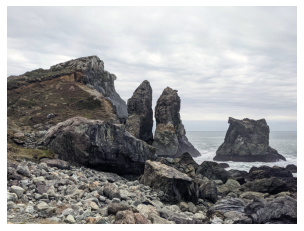

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.preprocessing.image.load_img(base_image_path))

我们使用北加州海岸的景色,作为测试图片.


我们需要一个预训练的网络,在 keras 中有许多网络可供选择: VGG16 VGG19 Xception ResNet50 等,不同的选择会影响最好的可视化,虽然都是在 imagenet 数据集上训练的模型,但是获取的权重各有不同.最初的 DeepDream 使用卷积网络是 Inception 模型,在实践中 Inception 模型被认为可以产生漂亮的 DeepDream.所以我们将使用 keras 中的 Inception V3 模型.


In [2]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}  # 所有试图最大化的层名称 以及他们在总损失的权重,可以调整这些设置获取新的效果
outputs_dict = dict([
    (layer.name, layer.output)
    for layer in [model.get_layer(name) for name in layer_settings.keys()]
])  #获取每一层的输出
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)  # 模型会 返回每个目标层的激活值


我们使用预训练的 cnn 创建一个精确的模型,返回各个中间层的激活.

In [4]:
def compute_loss(input_image):
    features = feature_extractor(input_image) #提取激活
    loss = tf.zeros(shape=()) #全0
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) # 避开边界像素,避免伪影
    return loss

接下来是计算损失(loss),即梯度上升过程中需要最大化的量.第9章过滤器可视化中,我们试图将某一层的过滤器值最大化,这里我们要将所有层的过滤器同时最大化.

具体而言是将一组靠近顶部的层激活的 L2 范数进行加权求和,然后将其最大化.选择那些层对最终结果影响甚大,更靠近底层越像几何图案,更靠近顶层越接近 imagenet 已有图片,这里是随意选择了 4 层.


In [5]:
import tensorflow as tf


@tf.function  # 注解加速
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)  # DeepDream 梯度相对于当前图像的关系
    grads = tf.math.l2_normalize(grads)  # 归一化梯度与第二章相同
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image,
                         iterations,
                         learning_rate,
                         max_loss=None):  #为给定的图像比例运行梯度上升
    for i in range(iterations):  #增加DeepDream损失的方式反复更新图像
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:  # 如果损失超过一定的阈值，则退出（过度优化会产生不需要的图像伪影）。
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

接下来是要在每个轮次上运行梯度上升,这与第 9 章的滤波器可视化是相同的.DeepDream 是一种多尺度的滤波器可视化.

![deepdream_process](deepdream_process.png)

最后是 deepdream 算法,我们首先定义一个列表,里面包含了图像的尺度(八度),每个连续的尺度都是前一个的 1.4 倍.首先处理小图像,随后增大图像尺寸.


In [6]:
step = 20.  #梯度上升的步长
num_octave = 3  #梯度上升的次数
octave_scale = 1.4  #连续尺度直接的比例
iterations = 30  #每次迭代的梯度上升的步数
max_loss = 15.  #梯度上升的最大损失


上面是几个参数

In [7]:
import numpy as np


def preprocess_image(image_path):  #打开图片/调整图片大小/转化成数组
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img


def deprocess_image(img):  #num 转图片
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

每次连续放大之后,为了避免丢失大量细节.我们可以每次将丢失的细节重新注入图片.我们知道原始的图片放大到这个尺寸应该是什么样子.给定一个较小的图片尺寸 S 和一个较大的图片尺寸 L 可以计算将原始图像大小调整为 L 和 S 的区别,这个区别可以定量描述从 S 到 L 的损失.


In [8]:
original_img = preprocess_image(base_image_path)  #加载图片
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]  #计算不同倍频下的图像目标形状
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  #图像副本
for i, shape in enumerate(successive_shapes):  #遍历不同的 八度空间
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)  #调整图像大小
    img = gradient_ascent_loop(img,
                               iterations=iterations,
                               learning_rate=step,
                               max_loss=max_loss)  #梯度上升
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img,
                                                   shape)  #原始图像的缩小版本
    same_size_original = tf.image.resize(original_img, shape)  #计算同样尺寸下的高质量原始图像
    lost_detail = same_size_original - upscaled_shrunk_original_img  #损失的详细
    img += lost_detail  #丢失的细节重新注入
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img("dream.png",
                                   deprocess_image(img.numpy()))  #保存图片


Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.49
... Loss value at step 6: 2.84
... Loss value at step 7: 3.20
... Loss value at step 8: 3.52
... Loss value at step 9: 3.90
... Loss value at step 10: 4.22
... Loss value at step 11: 4.56
... Loss value at step 12: 4.91
... Loss value at step 13: 5.28
... Loss value at step 14: 5.66
... Loss value at step 15: 5.98
... Loss value at step 16: 6.31
... Loss value at step 17: 6.64
... Loss value at step 18: 6.93
... Loss value at step 19: 7.32
... Loss value at step 20: 7.58
... Loss value at step 21: 7.93
... Loss value at step 22: 8.25
... Loss value at step 23: 8.51
... Loss value at step 24: 8.82
... Loss value at step 25: 9.12
... Loss value at step 26: 9.39
... Loss value at step 27: 9.66
... Loss value at step 28: 9.94
... Loss value at step 29: 10.20
Process

![dream](./dream.png)

note:

Inception V3 原本是为了识别 299×299,因此 DeepDream 在 300×300 和 400×400 之间尺寸时表现最好,当然 DeepDream 可以在任意尺寸下运行.


---
当然可以自行调整上面选择的激活层,如果效果良好的话,可以有一堆的精神污染图了
---

DeepDream 相当于反向运行的 cnn,根据学到的特征生成输出.

结果就像,你也看到了,磕嗨了一样的迷幻图像.

要注意虽然上面是以图片示例,类似的生成过程可以存在任何模型,甚至不一定是 cnn 模型.可以生成语音,文字,音乐各个方面的内容.
